<a href="https://colab.research.google.com/github/shimazahabi/Rayan-AI-Course/blob/main/Homework_3_Shima_Zahabi.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Rayan International AI Contest**

<font color='black' style='font-family: "Times New Roman", Times, serif; font-size: 24px;'><strong>Machine Learning & Deep Learning Course </strong></font>

<font color='black' style='font-family: "Times New Roman", Times, serif; font-size: 20px;'><em>**Homework 3** || **Title**: Variational Autoencoder</em></font>


## Import Libraries

In [ ]:
import os

import torch
import torch.nn as nn
import torch.nn.functional as F

## Parameter Settings


Here we define some key hyperparameters:

- **Latent Dimensions (`latent_dims = 2`)**: Allows for easy 2D visualization of the results.
- **Epochs (`num_epochs = 30`)**: The model will train for 30 iterations.
- **Batch Size (`batch_size = 128`)**: 128 samples are processed at a time.
- **Capacity (`capacity = 64`)**: Determines the model's initial complexity.
- **Learning Rate (`learning_rate = 1e-3`)**: Controls the step size during optimization.
- **Variational Beta (`variational_beta = 1`)**: Balances reconstruction and regularization.
- **Use GPU (`use_gpu = True`)**: Enables faster training with GPU support.


In [ ]:
latent_dims = 2
num_epochs = 30
batch_size = 128
capacity = 64
learning_rate = 1e-3
variational_beta = 1
use_gpu = True

We will use MNIST as always. Fill the required lines

In [ ]:
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from torchvision.datasets import MNIST

img_transform = transforms.Compose([
    transforms.ToTensor()
])

train_dataset = MNIST(root='mnist_data', train=True, transform=img_transform, download=True)
train_dataloader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)

test_dataset = MNIST(root='mnist_data', train=False, transform=img_transform, download=True)
test_dataloader = DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False)

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 9912422/9912422 [00:00<00:00, 14501939.28it/s]


Extracting mnist_data/MNIST/raw/train-images-idx3-ubyte.gz to mnist_data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 28881/28881 [00:00<00:00, 474353.66it/s]


Extracting mnist_data/MNIST/raw/train-labels-idx1-ubyte.gz to mnist_data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 1648877/1648877 [00:00<00:00, 4375523.63it/s]


Extracting mnist_data/MNIST/raw/t10k-images-idx3-ubyte.gz to mnist_data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 4542/4542 [00:00<00:00, 3158767.83it/s]

Extracting mnist_data/MNIST/raw/t10k-labels-idx1-ubyte.gz to mnist_data/MNIST/raw



## Variational Autoencoder (VAE) Implementation

This code defines a Variational Autoencoder (VAE) using PyTorch. A VAE is a type of generative model that learns to encode input data into a latent space, then decode it back to the original data distribution.

### **Encoder Class**
The `Encoder` class maps input images into a latent space:
- **Convolutional Layers (`conv1`, `conv2`)**: Reduce the spatial dimensions of the input while increasing depth (channels) to extract features.
- **Fully Connected Layers (`fc_mu`, `fc_logvar`)**: Map the output features to the mean (`mu`) and log variance (`logvar`) of the latent space distribution.

The output of convolutional layer should be passed to 2 Fully Connected Layers. One will predict the mu and the other will predict the log variance of the given image.

These 2 values are used to sample from the space of images that will allow the decoder to produce a corresponding image.

In [ ]:
class Encoder(nn.Module):
    def __init__(self):
        super(Encoder, self).__init__()
        c = capacity
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=c, kernel_size=4, stride=2, padding=1) # out: c x 14 x 14
        self.conv2 = nn.Conv2d(in_channels=c, out_channels=c*2, kernel_size=4, stride=2, padding=1) # out: c x 7 x 7
        self.fc_mu = nn.Linear(in_features=c * 2 * 7 * 7, out_features=latent_dims)
        self.fc_logvar = nn.Linear(in_features=c * 2 * 7 * 7, out_features=latent_dims)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = x.view(x.size(0), -1) # flatten batch of multi-channel feature maps to a batch of feature vectors. Ready to feed to FC layer
        x_mu = self.fc_mu(x)
        x_logvar = self.fc_logvar(x)
        return x_mu, x_logvar

### **Decoder Class**
The `Decoder` class reconstructs the input data from the latent space:
- **Fully Connected Layer (`fc`)**: Expands the latent vector back into a feature map.
- **Transpose Convolutional Layers (`conv2`, `conv1`)**: Upsample the feature maps back to the original image size.
- **Sigmoid Activation**: Applied in the last layer to produce outputs suitable for binary cross-entropy loss.

Decoder is like the opposite of the encoder. Takes in two numbers and outputs an image.

In [ ]:
class Decoder(nn.Module):
    def __init__(self):
        super(Decoder, self).__init__()
        c = capacity
        self.fc = nn.Linear(in_features=latent_dims, out_features=c*2*7*7)
        # For architecture of the cnn use the reverse of the one used in Encoder
        # Remeber to use Transpose Convolution instead of the regular one
        self.conv2 = nn.ConvTranspose2d(in_channels=c * 2, out_channels=c, kernel_size=4, stride=2, padding=1)
        self.conv1 = nn.ConvTranspose2d(in_channels=c, out_channels=1, kernel_size=4, stride=2, padding=1)

    def forward(self, x):
        x = self.fc(x)
        x = x.view(x.size(0), capacity*2, 7, 7) # unflatten batch of feature vectors to a batch of multi-channel feature maps
        x = F.relu(self.conv2(x))
        x = self.conv1(x)
        x = torch.sigmoid(x) # last layer before output is sigmoid, since we are using BCE as reconstruction loss
        return x

### **VariationalAutoencoder Class**
Now it is time to define the VAE.
The `VariationalAutoencoder` class ties the encoder and decoder together:
- **Forward Pass**: Encodes the input to get `mu` and `logvar`, samples from the latent space, and decodes the sample back into an image.
- **Latent Sampling (`latent_sample`)**: Implements the reparameterization trick, allowing gradients to pass through the stochastic sampling process during training.

In [ ]:
class VariationalAutoencoder(nn.Module):
    def __init__(self):
        super(VariationalAutoencoder, self).__init__()
        self.encoder = Encoder()
        self.decoder = Decoder()

    def forward(self, x):
        latent_mu, latent_logvar = self.encoder(x)
        latent = self.latent_sample(latent_mu, latent_logvar)
        x_recon = self.decoder(latent)
        return x_recon, latent_mu, latent_logvar

    def latent_sample(self, mu, logvar):
        if self.training:
            # the reparameterization trick
            std = logvar.mul(0.5).exp_()
            eps = torch.empty_like(std).normal_()
            return eps.mul(std).add_(mu)
        else:
            return mu

### **Loss Function (`vae_loss`)**
This part is basicly the heart of VAE. A good loss will teach the model our target which is to predict mean and variance of distribution for an input image. It should also teach the decoder to produce the result for a sample.
The VAE loss consists of two parts:
- **Reconstruction Loss**: Binary cross-entropy between the input and reconstructed images, encouraging the decoder to produce outputs close to the original inputs.
- **KL Divergence**: A regularization term that ensures the learned latent distribution is close to a standard normal distribution, aiding in generating new, diverse samples.

In [ ]:
def vae_loss(recon_x, x, mu, logvar):

    recon_loss = F.binary_cross_entropy(recon_x.view(-1, 784), x.view(-1, 784), reduction='sum')
    kldivergence = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())

    return recon_loss + variational_beta * kldivergence

Now as usual we can define the VAE and import it to GPU

In [ ]:
vae = VariationalAutoencoder()

device = torch.device("cuda:0" if use_gpu and torch.cuda.is_available() else "cpu")
vae = vae.to(device)

num_params = sum(p.numel() for p in vae.parameters() if p.requires_grad)
print('Number of parameters: %d' % num_params)

Number of parameters: 308357


Train VAE
--------

In [ ]:
optimizer = torch.optim.Adam(params=vae.parameters(), lr=learning_rate, weight_decay=1e-5)

Now we have to define the training loop. Use what you have learned up to this point to write the loop


In [ ]:
# set to training mode
vae.train()

train_loss_avg = []

print('Training ...')
for epoch in range(num_epochs):
    train_loss_avg.append(0)
    num_batches = 0

    for image_batch, _ in train_dataloader:
        image_batch = image_batch.to(device)

        optimizer.zero_grad()

        mu, logvar = vae.encoder(image_batch)

        std = torch.exp(0.5 * logvar)
        z = mu + std * torch.randn_like(std)

        reconstructed_batch = vae.decoder(z)

        recon_loss = F.binary_cross_entropy(reconstructed_batch, image_batch, reduction='sum')

        kl_loss = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())

        loss = recon_loss + kl_loss

        loss.backward()

        optimizer.step()

        train_loss_avg[-1] += loss.item()
        num_batches += 1

    train_loss_avg[-1] /= num_batches
    print('Epoch [%d / %d] average reconstruction error: %f' % (epoch+1, num_epochs, train_loss_avg[-1]))

Training ...
Epoch [1 / 30] average reconstruction error: 23368.931661
Epoch [2 / 30] average reconstruction error: 20989.266081
Epoch [3 / 30] average reconstruction error: 20463.828975
Epoch [4 / 30] average reconstruction error: 20193.756748
Epoch [5 / 30] average reconstruction error: 20007.547483
Epoch [6 / 30] average reconstruction error: 19863.197403
Epoch [7 / 30] average reconstruction error: 19756.303938
Epoch [8 / 30] average reconstruction error: 19666.310416
Epoch [9 / 30] average reconstruction error: 19603.909080
Epoch [10 / 30] average reconstruction error: 19538.397798
Epoch [11 / 30] average reconstruction error: 19478.046448
Epoch [12 / 30] average reconstruction error: 19429.572091
Epoch [13 / 30] average reconstruction error: 19384.086966
Epoch [14 / 30] average reconstruction error: 19346.313718
Epoch [15 / 30] average reconstruction error: 19303.618678
Epoch [16 / 30] average reconstruction error: 19272.044120
Epoch [17 / 30] average reconstruction error: 19240.

Plot Training Curve
--------------------

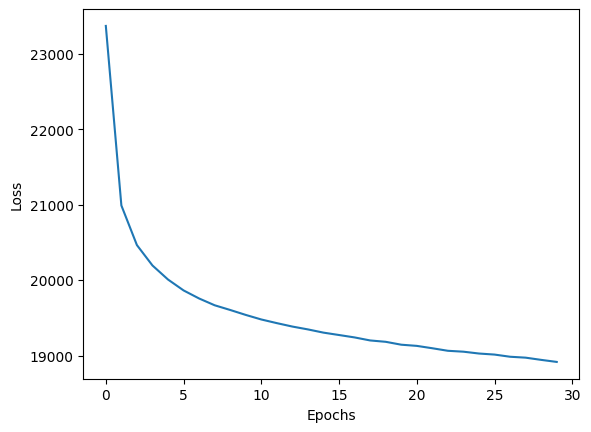

In [ ]:
import matplotlib.pyplot as plt
plt.ion()

fig = plt.figure()
plt.plot(train_loss_avg)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.show()

Alternatively: Load Pre-Trained VAE

Evaluate on the Test Set
-------------------------

In [ ]:
# set to evaluation mode
vae.eval()

test_loss_avg, num_batches = 0, 0
for image_batch, _ in test_dataloader:

    with torch.no_grad():

        image_batch = image_batch.to(device)

        # vae reconstruction
        image_batch_recon, latent_mu, latent_logvar = vae(image_batch)

        # reconstruction error
        loss = vae_loss(image_batch_recon, image_batch, latent_mu, latent_logvar)

        test_loss_avg += loss.item()
        num_batches += 1

test_loss_avg /= num_batches
print('average reconstruction error: %f' % (test_loss_avg))

average reconstruction error: 19006.003004


Visualize Reconstructions
--------------------------

Now let's test and see how similar is the output to the input image

Original images


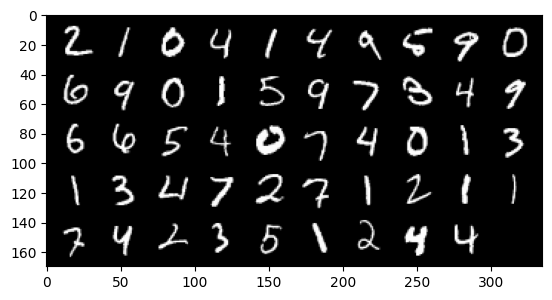

VAE reconstruction:


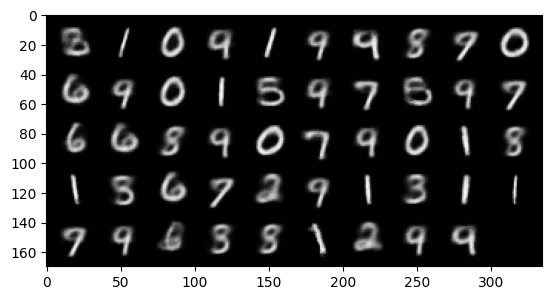

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
plt.ion()

import torchvision.utils

vae.eval()

# This function takes as an input the images to reconstruct
# and the name of the model with which the reconstructions
# are performed
def to_img(x):
    x = x.clamp(0, 1)
    return x

def show_image(img):
    img = to_img(img)
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))

def visualise_output(images, model):

    with torch.no_grad():

        images = images.to(device)
        images, _, _ = model(images)
        images = images.cpu()
        images = to_img(images)
        np_imagegrid = torchvision.utils.make_grid(images[1:50], 10, 5).numpy()
        plt.imshow(np.transpose(np_imagegrid, (1, 2, 0)))
        plt.show()

images, labels = next(iter(test_dataloader))

# First visualise the original images
print('Original images')
show_image(torchvision.utils.make_grid(images[1:50],10,5))
plt.show()

# Reconstruct and visualise the images using the vae
print('VAE reconstruction:')
visualise_output(images, vae)

Interpolate in Latent Space
----------------------------

Since the Decoder only needs a sample to create an image, it is fairly easy to produce interpolation of two image.
1. First we will provide each of the images to the Encoder.
2. After getting the `mu` for both of them we can create a sample from each image distribution without using the variances (`logvar`). Why is that?
3. We will use `lambda1` to get a point between the two samples using weighted average.

In [ ]:
def interpolation(lambda1, model, img1, img2):
    model.eval()
    with torch.no_grad():
        img1 = img1.to(next(model.parameters()).device)
        img2 = img2.to(next(model.parameters()).device)

        mu1, _ = model.encoder(img1)
        mu2, _ = model.encoder(img2)

        # interpolation of the two latent vectors
        inter_latent = lambda1 * mu1 + (1 - lambda1) * mu2

        # reconstruct interpolated image
        inter_image = model.decoder(inter_latent)
        inter_image = inter_image.cpu()

        return inter_image

Having the `interpolation` function, Now we can perform our interpolation.

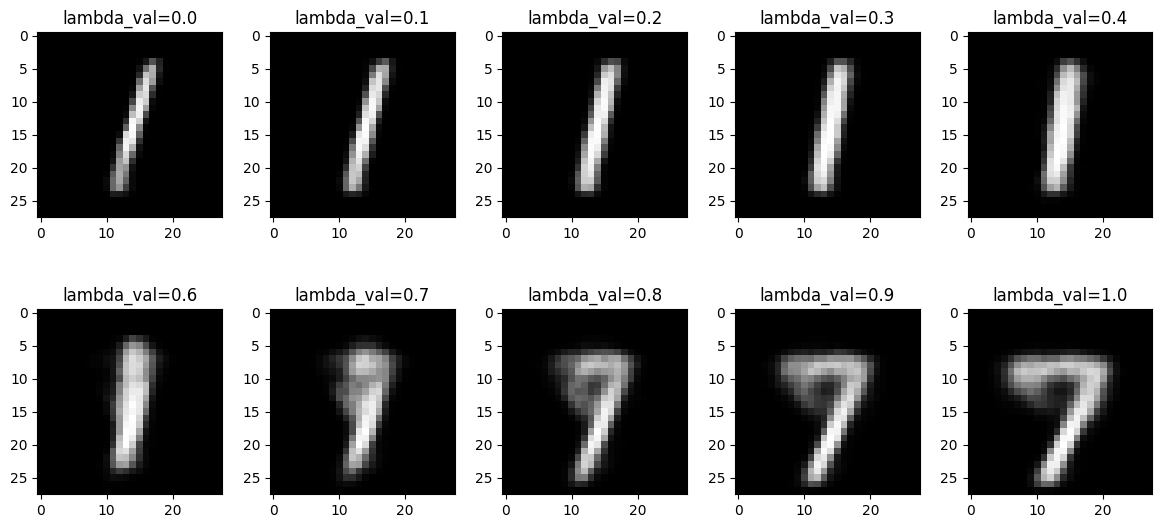

In [ ]:
vae.eval()

# sort part of test set by digit
digits = [[] for _ in range(10)]
for img_batch, label_batch in test_dataloader:
    for i in range(img_batch.size(0)):
        digits[label_batch[i]].append(img_batch[i:i+1])
    if sum(len(d) for d in digits) >= 1000:
        break;

# interpolation lambdas
lambda_range=np.linspace(0,1,10)

fig, axs = plt.subplots(2,5, figsize=(15, 6))
fig.subplots_adjust(hspace = .5, wspace=.001)
axs = axs.ravel()

for ind,l in enumerate(lambda_range):
    inter_image=interpolation(float(l), vae, digits[7][0], digits[1][0])

    inter_image = to_img(inter_image)

    image = inter_image.numpy()

    axs[ind].imshow(image[0,0,:,:], cmap='gray')
    axs[ind].set_title('lambda_val='+str(round(l,1)))
plt.show()

Show 2D Latent Space
---------------------

Now it is time a for a really cool experiment to see how the Decoder will react to sample from any point in the latent space (The space the sampled points come from an then are feeded to the Encoder and input of Decoder)

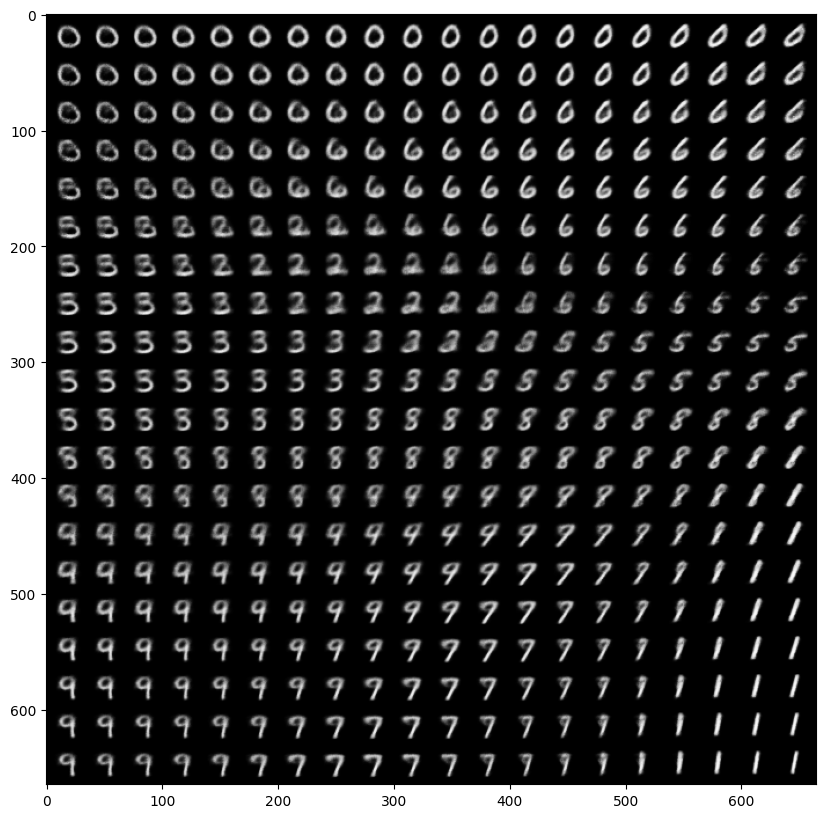

In [ ]:
# load a network that was trained with a 2d latent space
if latent_dims != 2:
    print('Please change the parameters to two latent dimensions.')

with torch.no_grad():

    # create a sample grid in 2d latent space
    latent_x = np.linspace(-1.5,1.5,20)
    latent_y = np.linspace(-1.5,1.5,20)
    latents = torch.FloatTensor(len(latent_y), len(latent_x), 2)
    for i, lx in enumerate(latent_x):
        for j, ly in enumerate(latent_y):
            latents[j, i, 0] = lx
            latents[j, i, 1] = ly
    latents = latents.view(-1, 2) # flatten grid into a batch

    # reconstruct images from the latent vectors
    latents = latents.to(device)
    image_recon = vae.decoder(latents)
    image_recon = image_recon.cpu()

    fig, ax = plt.subplots(figsize=(10, 10))
    show_image(torchvision.utils.make_grid(image_recon.data[:400],20,5))
    plt.show()

The results are really good. But there is only one problem.

**Why are most of the outputs blurry?**

# Stable Diffusion

Stable Diffusion is a technique used for generating high-quality images from text descriptions. It works by gradually adding noise to an image and then reversing the process to refine the image, guided by the text prompt. The model starts with random noise and iteratively denoises it, aligning the output with the input text. This approach allows for creating detailed and coherent images, making it popular for various creative applications.

You can read more about diffusion models <a href="https://colab.research.google.com/github/huggingface/notebooks/blob/main/diffusers/diffusers_intro.ipynb">here</a>


## Setup & Imports

In [ ]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

Sun Sep 15 18:19:36 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   55C    P8               9W /  70W |      0MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [ ]:
!pip install --upgrade transformers==4.40.0 diffusers==0.27.2 ftfy==6.2.0 accelerate datasets bitsandbytes

In [ ]:
from argparse import Namespace
import math
from tqdm.auto import tqdm
from PIL import Image
import torch
from torch import autocast
from torchvision import transforms
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset
from transformers import CLIPTextModel, CLIPTokenizer
from diffusers import AutoencoderKL, UNet2DConditionModel, PNDMScheduler, LMSDiscreteScheduler, DDPMScheduler
from accelerate import Accelerator
from accelerate.utils import set_seed
import bitsandbytes as bnb

In [ ]:
height = 512                        # default height of Stable Diffusion
width = 512                         # default width of Stable Diffusion
num_inference_steps = 50           # Number of denoising steps
guidance_scale = 8                # Scale for classifier-free guidance
generator = torch.manual_seed(64)   # Seed generator to create the inital latent noise
batch_size = 1
torch_device = "cuda" if torch.cuda.is_available() else "cpu"
device = torch_device

## Importing Models

Stable Diffusion utilizes multiple models to operate. As it is demonstrated in the image below the process consists of multiple steps:
- The process starts with a tensor of random numbers, chosen as the initial embedding of the image.
- Simultaneously, a text prompt provided by the user is tokenized and converted into an embedding.
- Both embeddings are combined and fed into a U-Net model.
- The U-Net model goes through multiple iterations, gradually reducing the noise in the image.
- The scheduler defines the algorithm for noise reduction.
- Finally, the refined embedding is passed through the decoder of a VAE (Variational Autoencoder) to produce the output image.


<p align="left">
<img src="https://raw.githubusercontent.com/patrickvonplaten/scientific_images/master/stable_diffusion.png" alt="sd-pipeline" width="500"/>
</p>


To start, first we have to import all the required models.

In [ ]:
# Load the autoencoder model which will be used to decode the latents into image space.
vae = AutoencoderKL.from_pretrained("CompVis/stable-diffusion-v1-4", subfolder="vae")
tokenizer = CLIPTokenizer.from_pretrained("openai/clip-vit-large-patch14")
text_encoder = CLIPTextModel.from_pretrained("openai/clip-vit-large-patch14")
# The UNet model for generating the latents
unet = UNet2DConditionModel.from_pretrained("CompVis/stable-diffusion-v1-4", subfolder="unet")
scheduler = PNDMScheduler.from_pretrained("CompVis/stable-diffusion-v1-4", subfolder="scheduler")
vae = vae.to(torch_device)
text_encoder = text_encoder.to(torch_device)
unet = unet.to(torch_device)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1150: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:99: UserWarning: 
Error while fetching `HF_TOKEN` secret value from your vault: 'Requesting secret HF_TOKEN timed out. Secrets can only be fetched when running from the Colab UI.'.
You are not authenticated with the Hugging Face Hub in this notebook.
If the error persists, please let us know by opening an issue on GitHub (https://github.com/huggingface/huggingface_hub/issues/new).
  warnings.warn(


vae/config.json:   0%|          | 0.00/551 [00:00<?, ?B/s]

diffusion_pytorch_model.safetensors:   0%|          | 0.00/335M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/905 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/961k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/525k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/389 [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/2.22M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/4.52k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.71G [00:00<?, ?B/s]

unet/config.json:   0%|          | 0.00/743 [00:00<?, ?B/s]

diffusion_pytorch_model.safetensors:   0%|          | 0.00/3.44G [00:00<?, ?B/s]

scheduler/scheduler_config.json:   0%|          | 0.00/313 [00:00<?, ?B/s]

We will define a function to convert the latent outputs to images.

In [ ]:
def latents_to_pil(latents):

    # bath of latents -> list of images
    latents = (1 / 0.18215) * latents
    with torch.no_grad():
        image = vae.decode(latents).sample
    image = (image / 2 + 0.5).clamp(0, 1)
    image = image.detach().cpu().permute(0, 2, 3, 1).numpy()
    images = (image * 255).round().astype("uint8")
    pil_images = [Image.fromarray(image) for image in images]
    return pil_images

## Prompt to Embedding


To provide the U-net model with text guidance, we need to convert text inputs to embeddings.

It's important to note that the U-net model requires a positive embedding and also a negative embedding. The code for positive embedding is provided to you. As part of the homework try writing the code for getting the negative embedding. Since we are not going to provide any negative prompt, You can use empty strings.

In [ ]:
def prompt_to_emb(prompt, negative_prompt=""):
    # Tokenize the prompts
    batch_size = len(prompt)

    # Convert the text prompts into tokenized inputs with fixed max length
    text_inputs = tokenizer(
        prompt,
        padding="max_length",
        max_length=77,  # Maximum token length
        truncation=True,  # Truncate if the prompt exceeds max_length
        return_tensors="pt",  # Return as PyTorch tensors
    )
    text_input_ids = text_inputs.input_ids

    # Encode the tokenized inputs into embeddings using the text encoder
    prompt_embeds = text_encoder(text_input_ids.cuda())
    prompt_embeds = prompt_embeds[0]  # Extract the embeddings

    # Get the data type of the embeddings
    prompt_embeds_dtype = text_encoder.dtype

    # Ensure embeddings are in the correct dtype and on the correct device
    prompt_embeds = prompt_embeds.to(dtype=prompt_embeds_dtype, device=device)

    # Get the sequence length from the embeddings
    _, seq_len, _ = prompt_embeds.shape

    # Repeat and reshape the embeddings for further processing
    prompt_embeds = prompt_embeds.repeat(1, 1, 1)
    prompt_embeds = prompt_embeds.view(batch_size * 1, seq_len, -1)
    max_length = prompt_embeds.shape[1]

    ##################################
    negative_text_inputs = tokenizer(
        [negative_prompt] * batch_size,
        padding="max_length",
        max_length=77,
        truncation=True,
        return_tensors="pt",
    )
    negative_text_input_ids = negative_text_inputs.input_ids

    negative_prompt_embeds = text_encoder(negative_text_input_ids.cuda())
    negative_prompt_embeds = negative_prompt_embeds[0]

    negative_prompt_embeds = negative_prompt_embeds.to(dtype=prompt_embeds_dtype, device=device)

    negative_prompt_embeds = negative_prompt_embeds.repeat(1, 1, 1)
    negative_prompt_embeds = negative_prompt_embeds.view(batch_size * 1, seq_len, -1)

    # Finally Concatenate the unconditional and prompt embeddings
    concatenated_embeddings = torch.cat([negative_prompt_embeds, prompt_embeds])

    # Return the concatenated embeddings
    return concatenated_embeddings
prompt_embeddings = prompt_to_emb(["A photo of a cat"])
print(prompt_embeddings.shape)

torch.Size([2, 77, 768])


## Embeding to Latents

This is the part where the input Embeddings go through multiple iterations to produce the image embedding.

In [ ]:
def emb_to_latents(text_embeddings):

    scheduler.set_timesteps(num_inference_steps)

    # Generate random latent noise for the input to the model
    latents = torch.randn((1, 4, 64, 64),dtype=torch.float32).to(torch_device)

    for t in tqdm(scheduler.timesteps):
        # Duplicate the random latent noise
        latent_model_input = torch.cat([latents] * 2)

        # Scale the model input
        latent_model_input = scheduler.scale_model_input(latent_model_input, t)
        with torch.no_grad():
            noise_pred = unet(latent_model_input, t, encoder_hidden_states=text_embeddings,return_dict=False,added_cond_kwargs={'text_embeds':text_embeddings})[0]

        # Apply classifier-free guidance scale
        noise_pred_uncond, noise_pred_text = noise_pred.chunk(2)
        noise_pred = noise_pred_uncond + guidance_scale * (noise_pred_text - noise_pred_uncond)

        latents = scheduler.step(noise_pred, t, latents,return_dict=False)[0]

    return latents

## Evaluate

Let's try the pipeline with a few examples.

  0%|          | 0/51 [00:00<?, ?it/s]

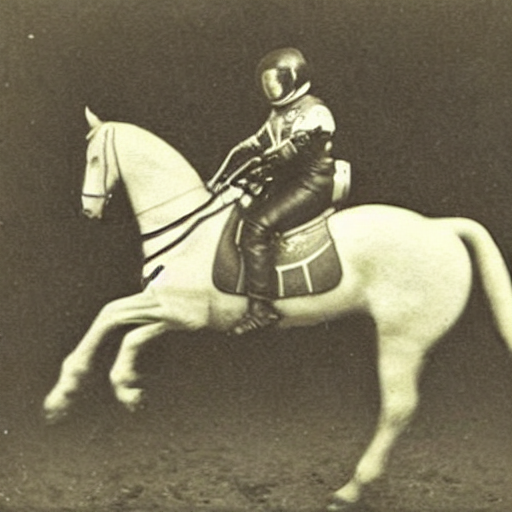

In [ ]:
prompt = ["a photograph of an astronaut riding a horse"]
text_embeddings = prompt_to_emb(prompt)
latents = emb_to_latents(text_embeddings)
image = latents_to_pil(latents)
image[0]

  0%|          | 0/51 [00:00<?, ?it/s]

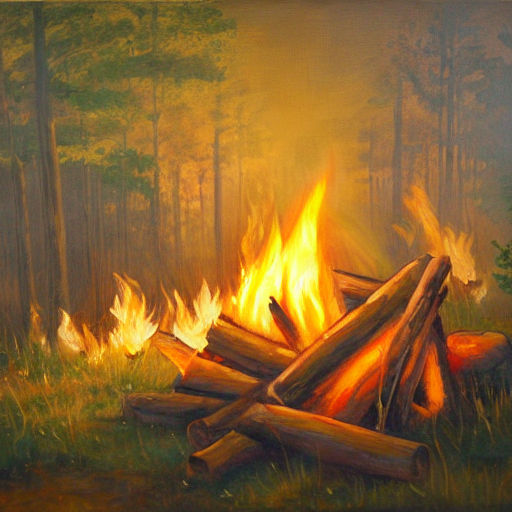

In [ ]:
prompt = ["a campfire (oil on canvas)"]
text_embeddings = prompt_to_emb(prompt)
latents = emb_to_latents(text_embeddings)
image = latents_to_pil(latents)
image[0]